<a href="https://colab.research.google.com/github/AlexeyTri/MedSeminars_spring/blob/master/seminar1/%D0%9B%D0%B8%D0%BD%D0%B5%D0%B9%D0%BD%D1%8B%D0%B9_%D0%BA%D0%BB%D0%B0%D1%81%D1%81%D0%B8%D1%84%D0%B8%D0%BA%D0%B0%D1%82%D0%BE%D1%80_%D0%B8_%D1%81%D1%82%D0%BE%D1%85%D0%B0%D1%81%D1%82%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%B8%D0%B9_%D0%B3%D1%80%D0%B0%D0%B4%D0%B8%D0%B5%D0%BD%D1%82.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Линейные методы классификации и регрессии, метод стохастического градиентного спуска**

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import gridspec
from scipy.special import expit
from tqdm.notebook import tqdm
import seaborn as sns
import pandas as pd
import torch
import numpy as np

from sklearn.linear_model import (LogisticRegression, LinearRegression)
# выбор модели по минимуму функционала ошибки -> перебор валидационной выборки
from sklearn.model_selection import LeaveOneOut, KFold

In [ ]:
# пример дифференцирования
w = torch.ones(3, requires_grad=True)

q = w.T@w
q.backward()
print(w.grad)

<ipython-input-2-56239f3c1f4a>:4: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3277.)
  q = w.T@w


tensor([2., 2., 2.])


# Опитимизационные задачи

задача оптимизации

\begin{align}
\hat{𝐰} = argmin_{𝐰\in{𝕎}}{ℒ}(𝐰,X, y)
\end{align}

как правило данные задачи решают двумя способами:

1. аналитическое решение - не все ${ℒ}$ имеют решение
2. стохастический градиентный спуск

## аналитическое решение для задач линейной регрессии: $y\in ℝ ^{n}$

* линейная модель регресии:

\begin{align}
 {𝓕} = \{ f(w, x) = w^{⊤}x|w \in ℝ ^{n}\}
\end{align}


* решаем следующую оптимизационную задачу:


\begin{align}
\hat\theta = argmin_{{𝐰}\in{ℝ ^{n}}}\frac{1}{l}\sum_{i=1}^l \left(w^{⊤}x_{i} - y_{i} \right)^2
\end{align}

в матричном виде:


\begin{align}
\sum_{i=1}^l \left(w^{⊤}x_{i} - y_{i} \right)^2 =\left(Xw - y\right)^{⊤}\left(Xw - y\right) &= w^{⊤}X^{⊤}Xw - 2yXw + y^{⊤}y
\end{align}

* для нахождения оптимального $w$ найдем точку экстремума:


\begin{align}
\frac{∂}{\partial w}\left(w^{⊤}X^{⊤}Xw - 2yXw + y^{⊤}y\right) = 0 = 2X^{⊤}Xw - 2X^{⊤}y \implies \hat{w} = \left(X^{⊤}X\right)^{-1}X^{⊤}y
\end{align}



In [ ]:
# пример аналитического решения задачи регресии
np.random.seed(0)
l = 40

# ГЕНЕРАЦИЯ ДАННЫХ 
x = np.linspace(0, 30, num=l)
Y = x + 4*np.sin(x) + 3 *np.random.randn(l)

# Генерация признаков
X = np.vstack([np.ones_like(x), x, np.sin(x)]).T

#Аналитическое решение
w = np.linalg.inv(X.T@X)@X.T@Y

<function matplotlib.pyplot.show(*args, **kw)>

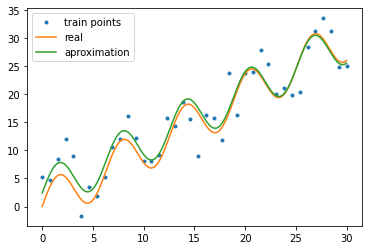

In [ ]:
plt.plot(x, Y, ".", label="train points")

x_plot = np.linspace(0, 30, num=10000)
plt.plot(x_plot, 4*np.sin(x_plot) + x_plot, label="real" )

X_plot = np.vstack([np.ones_like(x_plot), x_plot, np.sin(x_plot)]).T
plt.plot(x_plot, X_plot@w, label="aproximation")

plt.legend(loc="best")
plt.show

## модель линейной классификации

* линейная модель бинарной $\{-1, +1\}$ классификации:


\begin{align}
 {𝓕_{bcl}} = \{ f(w, x) = sign(w^{⊤}x)|w \in ℝ ^{n}\}
\end{align}


* выражая $w$, получаем следующую оптимизационную задачу:


\begin{align}
\hat{𝐰} = argmin_{𝐰\in{𝕎}}{ℝ ^{n}}\frac{1}{l}\sum_{i=1}^l \left[w^{⊤}x_{i} \ne y_{i} \right]=argmin_{𝐰\in{𝕎}}{ℝ ^{n}}\frac{1}{l}\sum_{i=1}^l \left[y_{i}w^{⊤}x_{i}<0 \right]
\end{align}

❗ данная задача не имеет аналитического решения. Применим метод градиетного спуска

\begin{align}
\hat{𝐰} = argmin_{𝐰\in{ℝ ^{n}}}\frac{1}{l}\sum_{i=1}^l \log_{2}(1 + e^{-y_{i}w^{⊤}x_{i}})
\end{align}


<function matplotlib.pyplot.show(*args, **kw)>

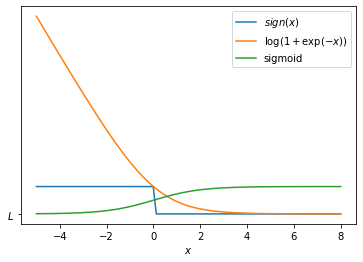

In [ ]:
def sign(x):
    # функция не дифференцируема, что видно на графике
    return np.array(x <= 0, dtype=np.int64)

def upper_bound(x):
    # логистическая функция
    return np.log2(1 + np.exp(-x))

x = np.linspace(-5, 8, 100)
plt.plot(x, sign(x), label="$sign(x)$")
plt.plot(x, upper_bound(x), label="$\log(1+\exp(-x))$")
plt.plot(x, (1/(1+ np.exp(-x))), label="sigmoid")

plt.xlabel('$x$')
plt.plot("$L$")
plt.legend(loc="best")
plt.show

### стохастический градиентный спуск

* градиентный спуск:

\begin{align}
\hat{𝐰_{k+1}} = 𝐰_{k} - \alpha_{k} ∇{ℒ}(𝐰,X, y)
\end{align}

"минус" - долго считать сумму ${ℒ}(𝐰,X, y) = \frac{1}{l}\sum_{i=1}^l q\left(w,x_{i},y_{i} \right)$

* рассмотрим стохастический градиентный спуск


\begin{align}
\hat{𝐰_{k+1}} = 𝐰_{k} - \alpha_{k} ∇q\left(w,x_{ik},y_{ik} \right)
\end{align}

❗если индекс объекта $ik$ сгенерирован равновероятно, то справедливо равенство:


\begin{align}
Ε∇q\left(w,x_{ik},y_{ik} \right) = \frac{1}{l}\sum_{i=1}^l q\left(w,x_{i},y_{i} \right) = ∇{ℒ}(𝐰,X, y)
\end{align}


### анализ сходимости стохастического градиента

\begin{align}
{ℒ}(𝐰) = \frac{1}{l}\sum_{i=1}^l q\left(w,i\right)⟶ \min_{w}
\end{align}

${ℒ}(𝐰)$ выпуклая по $w$

* стохастический градиентный спуск:


\begin{align}
\hat{𝐰_{k+1}} = 𝐰_{k} - \alpha_{k} \hat g_{k}\\\\
Ε\hat g{k} = g_{k} = ∇{ℒ}(𝐰) 
\end{align}

* рассмотрим норму невязки:
\begin{align}
||𝐰_{k+1} - 𝐰^{*}||^{2} = ||𝐰_{k} - 𝐰^{*} - \alpha_{k} \hat g_{k}||^{2} = ||𝐰_{k} - 𝐰^{*}||^{2} - 2\alpha_{k} \hat g_{k}{⊤}(𝐰_{k} - 𝐰^{*}) + 2\alpha_{k}^{2} ||\hat g_{k}||^{2}\\\\
Ε||𝐰_{k+1} - 𝐰^{*}||^{2} = ||𝐰_{k} - 𝐰^{*}||^{2} - 2\alpha_{k} \hat g_{k}^{⊤}(𝐰_{k} - 𝐰^{*}) + 2\alpha_{k}^{2} Ε||\hat g_{k}||^{2}\\\\
\alpha_{k} \hat g_{k}^{⊤}(𝐰_{k} - 𝐰^{*}) = \frac{1}{2}||𝐰_{k+1} - 𝐰^{*}||^{2} -\frac{1}{2}Ε||𝐰_{k+1} - 𝐰^{*}||^{2}+\frac{\alpha_{k}^{2}}{2} Ε||\hat g_{k}||^{2}\\
\text{в силу выпуклости ℒ, справедливо следующее неравенство:}\\
{ℒ}(𝐰_k) - {ℒ}(𝐰^{*}) \le g_{k}^{⊤}(𝐰_{k} - 𝐰^{*})\\\\
\alpha_{k}({ℒ}(𝐰_k) - {ℒ}(𝐰^{*})) \le \frac{1}{2}||𝐰_{k+1} - 𝐰^{*}||^{2} -\frac{1}{2}Ε||𝐰_{k+1} - 𝐰^{*}||^{2}+\frac{\alpha_{k}^{2}}{2} Ε||\hat g_{k}||^{2}\\\\
\text{усредним по $g_k$ для всех k=1...K и проссумируем K первых итераций:}\\
\sum_{k=1}^{K}\alpha_{k}(Ε{ℒ}(𝐰_k) - {ℒ}(𝐰^{*})) \le \frac{1}{2}||𝐰_{0} - 𝐰^{*}||^{2} -\frac{1}{2}Ε||𝐰_{k+1} - 𝐰^{*}||^{2}+\sum_{k=1}^{K}\frac{\alpha_{k}^{2}}{2} Ε||\hat g_{k}||^{2}\le \frac{1}{2}||𝐰_{0} - 𝐰^{*}||^{2} + \sum_{k=1}^{K}\frac{\alpha_{k}^{2}}{2} Ε||\hat g_{k}||^{2}\\\\
\text{используем неравенство Йенсена для выпуклой функции ℒ:}\\
Ε{ℒ}(\frac{1}{\sum\alpha_k}\sum α_k𝐰_k) - {ℒ}(𝐰^{*})) \le \sum_{k=1}^{K}\alpha_k(Ε{ℒ}(𝐰_k) - {ℒ}(𝐰^{*}))\le \frac{1}{2}||𝐰_{0} - 𝐰^{*}||^{2} + \sum_{k=1}^{K}\frac{\alpha_{k}^{2}}{2} Ε||\hat g_{k}||^{2}\\\\
\text{для удобства введем обозначения и предположения:}\\
\hat{𝐰_{K}} = \frac{1}{\sum\alpha_k}\sum α_k𝐰_k\\
||𝐰_{0} - 𝐰^{*}||^{2} \le 𝑅^2\\
Ε||\hat g_{k}||^{2} \le 𝐺^2\\\\
\text{получаем оценку:}\\
Ε{ℒ}(\hat{𝐰_{K}}) - {ℒ}(𝐰^{*})) \le \frac {𝑅^2 +𝐺^2\sum α_k^2}{2\sum α_k^2}\\\\
\text{проанализируем выражение на скорость сходимости:}\\
\text{первый способ выбора шага:}\\
\sum α_k = ∞, \sum α_k^2 < ∞, \left[α_k = \frac{1}{k}\right], ≈ Q(\frac{1}{\log_{}K})\\\\
\text{второй способ выбора шага:}\\
\sum α_k = ∞, \frac{\sum α_k^2}{\sum α_k} = 0, \left[α_k = \frac{1}{\sqrt{k}}\right], ≈ Q(\frac{\log_{}K}{\sqrt{k}})\\\\
\text{ВЫВОД-?}\\
\end{align}

## задача бинарной классификации

\begin{align}
\hat{𝐰} = argmin_{𝐰\in{ℝ ^{n}}}\frac{1}{l}\sum_{i=1}^l \log_{2}(1 + e^{-y_{i}w^{⊤}x_{i}})
\end{align}

In [ ]:
torch.manual_seed(0)

l= 100
n=2

X = torch.randn([l, n])
w_true = torch.randn([n])
Y = torch.ones([l])

Y[X@w_true < 0 ] = -1

In [ ]:
torch.manual_seed(0)
np.random.seed(0)
w = torch.randn([n], requires_grad=True) #

K = l
list_of_loss_sqrt = []
for k in range(1, K+1):
    # считаем ошибку L на каждом шаге
    with torch.no_grad():
        list_of_loss_sqrt.append(
            torch.mean(torch.log2(1 + torch.exp(-Y*(X@w))))
        )
    # выбираем случайный элемент выборки
    ind = np.random.randint(low=0, high=l)
    # шаг затухания
    alpha = 1/np.sqrt(k)
    print(w)

    # считаем ошибку на элементе
    q = torch.log2(1 + torch.exp(-Y[ind] * (X[ind]@w)))
    print(q)

    # считаме q с крышкой
    q.backward()
    print(w.grad)

    # делаем градиентый шаг
    with torch.no_grad():
        # wk+1^=wk−αkg^k
        w.add_(w.grad, alpha=-1 * alpha)
    
    # обнуляем градиент
    w.grad.zero_()

In [ ]:
pred = torch.ones([l])
pred[X@w <0] = -1
print('точность прогноза : {}'.format(torch.mean((pred == Y).float()).item()))

точность прогноза : 0.9200000166893005


In [ ]:
torch.manual_seed(0)
np.random.seed(0)
w = torch.randn([n], requires_grad=True)

K = l
list_of_loss = []
for k in range(1, K+1):
    with torch.no_grad():
        list_of_loss.append(torch.mean(torch.log2(1+ torch.exp(-Y*(X@w)))))
    
    ind = np.random.randint(low=1, high=l)
    # шаг затухания
    alpha = 1/k

    q = torch.log2(1 + torch.exp(-Y[ind] * (X[ind]@w)))
    q.backward()

    with torch.no_grad():
        w.add_(w.grad, alpha=-1 * alpha)
    
    w.grad.zero_()
    

In [ ]:
torch.manual_seed(0)
w = torch.randn([n], requires_grad=True)

dataset = torch.utils.data.TensorDataset(X,Y)
generator = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True)

optimizer = torch.optim.SGD([w], lr=1)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lambda k: 1/np.sqrt(k+1))

list_of_loss_torch = []
for x, y in generator:
    optimizer.zero_grad() # обнуляем градиенты

    with torch.no_grad():
        list_of_loss_torch.append(
            torch.mean(torch.log2(1 + torch.exp(-Y*(X@w))))
        )

    q = torch.log2(1 + torch.exp(-y*(x@w))).mean()

    q.backward()

    optimizer.step()
    scheduler.step()

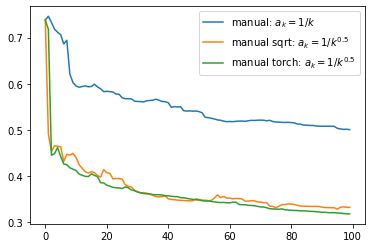

In [ ]:
plt.plot(list_of_loss, label="manual: $a_k = 1/k$")
plt.plot(list_of_loss_sqrt, label="manual sqrt: $a_k = 1/k^{0.5}$")
plt.plot(list_of_loss_torch, label="manual torch: $a_k = 1/k^{0.5}$")
plt.legend(loc="best")
plt.show()

## вероятностная постановка задачи классификации

### линейная регрессия

рассмотрим следуюшее вероятностное предположение о данных:

\begin{align}
y = w^{⊤}x + 𝜀, 𝜀 ~ 𝒩(0, β)\\\\
\text{пусть векторы w и x являются не случайными величинами, тогда получаем, что y является номальной случайной величиной.}\\
\text{пусть все объекты выборки являются независимыми случайными величинами, тогда получаем правдободобие выборки:}\\\\
𝑝(y|w, X) = \prod_{i=1}^{l}𝑝(y_{i}|x,w_{i})\\
𝑝(y_{i}|w,x_{i})~ 𝒩(w^{⊤}x_{i}, β)\\\\
\text{принципа максимума правдоподобия (максимизация логарифмической функции правдоподобия - минимизация функции эмпирического риска):}\\\\
${ℒ}(𝐰,X, y) = -\sum_{i=1}^l \log 𝑝(y_{i}|x,w_{i}) = \sum_{i=1}^l\left[\frac{β}{2}(w^{⊤}x_{i} - y_{i})^2 + C\right]\\
\text{решение ?}\\\\
\text{рассмотрим совместное правдоподобие модели и данных:}\\
𝑝(y|w, X) = \prod_{i=1}^{l}𝑝(y_{i}|x,w_{i})𝑝(w)
\text{рассмотрим}& 𝑝(w)~ 𝒩(0, ℽ𝐈)\\\\
\text{по принципу максимума правдоводобия:}\\
{ℒ}(𝐰,X, y) = -\sum_{i=1}^l \log 𝑝(y_{i}|x,w_{i}) - \log 𝑝(w_{i}) = \sum_{i=1}^l\left[\frac{β}{2}(w^{⊤}x_{i} - y_{i})^2 + C_{1}\right] + w^{⊤}w + C_{2}\\\\
\text{заметим, что данная задача имеет аналитическое решение:}\\
\hat{𝐰} = argmin_{𝐰\in{ℝ ^{n}}}\left[-\sum_{i=1}^l \log 𝑝(y_{i}|x,w_{i}) - \log 𝑝(w_{i}) \right] = argmin_{𝐰\in{ℝ ^{n}}}\left[\sum_{i=1}^l\left[\frac{β}{2}(w^{⊤}x_{i} - y_{i})^2 + C_{1}\right] + \frac{ℽ}{2}w^{⊤}w + C_{2}\right]
\end{align}

### логистическая регрессия


рассмотрим следующее вероятностное предположение о данных:

\begin{align}
y = 𝚩𝖾(σ(w^{⊤}x) &, σ(x) = \frac{1}{1+\exp(-x)}\\\\
\text{принцип максимума правдоподобия:}\\
{ℒ}(𝐰,X, y) = -\sum_{i=1}^l \log 𝑝(y_{i}|x,w_{i}) = \sum_{i=1}^l\left[y_i\logσ(w^{⊤}x) + (1-y_i)\log(1 - σ(w^{⊤}x))\right]+C\\
\text{рассмотрим совместное правдоподобие модели и данных
$𝑝(w) = 𝒩(0, ℽ𝐈)$}\\
\text{рассмотрим}& 𝑝(w)~ 𝒩(0, ℽ𝐈)\\
\text{по принципу максимума правдоводобия:}\\
{ℒ}(𝐰,X, y) = -\sum_{i=1}^l \log 𝑝(y_{i}|x,w_{i}) - \log 𝑝(w_{i}) = \sum_{i=1}^l\left[y_i\logσ(w^{⊤}x) + (1-y_i)\log(1 - σ(w^{⊤}x))\right]+C1] + \frac{𝛾}{2}w^{⊤}w + C_{2}\\\\
\end{align}

* Вывод - ?

In [ ]:
np.random.seed(0)
l = 50000
n = 2

X = np.random.randn(l, n)
w = np.random.randn(n)
Y = np.random.binomial(n=1, p=expit(X@w))

In [ ]:
gammas = [1e-10, 1e-4, 1e-3, 1e-2, .1, 1., 10., 1e2, 1e3, 1e4, 1e10]

models_l2 = dict()
for gamma in gammas:
    model = LogisticRegression(penalty='l2', C=2/gamma, fit_intercept=False, 
                               random_state=0, solver='saga')
    model.fit(X, Y)
    models_l2[gamma] = model
    
models_l1 = dict()
for gamma in gammas:
    model = LogisticRegression(penalty='l1', C=2/gamma, fit_intercept=False, 
                               random_state=0, solver='saga')
    model.fit(X, Y)
    models_l1[gamma] = model

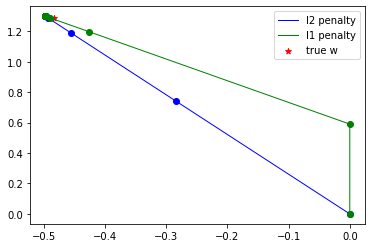

In [ ]:
x = [models_l2[gamma].coef_[0][0] for gamma in models_l2]
y = [models_l2[gamma].coef_[0][1] for gamma in models_l2]

plt.plot(x, y, 'bo')
plt.plot(x, y, 'b-', linewidth=1, label='l2 penalty')

x = [models_l1[gamma].coef_[0][0] for gamma in models_l1]
y = [models_l1[gamma].coef_[0][1] for gamma in models_l1]

plt.plot(x, y, 'go')
plt.plot(x, y, 'g-', linewidth=1, label='l1 penalty')
    
    
plt.scatter(w[0], w[1], marker='*', c='r', label='true w')
plt.legend(loc='best')
plt.show()

### поиск оптимального 𝛾

#### LOO Leave One Out

обозначим $\hatϴ(X)$ оптимальный ветор для выборки X. Тогда:

\begin{align}
LOO(\mu, X_{tr}, y_{tr}, X_{vl}, y_{vl}) = \sum_{i=1}^{l_{tr} + l_{vl}}𝑞(\hatϴ(X_{tr}\cup X_{vl}| x_i,μ), x_i,y_i)\\\\
\text{$x_i$ элемент из датасета обучения и валидации}\\
\hat\mu = argmin_{μ\in𝜧}LOO(\mu, X_{tr}, y_{tr}, X_{vl}, y_{vl})\\\
\hatϴ=\hatϴ(X_{tr}\cup X_{vl},\hat μ)
\text{применим LOO для поиска оптимального $\hatℽ$:}\\
\hatℽ = argmin_{ℽ\inΓ}LOO(\hatℽ = argmin_{ℽ\inΓ}LOO(\mu, X_{tr}, y_{tr}, X_{vl}, y_{vl})\\
LOO(\mu, X_{tr}, y_{tr}, X_{vl}, y_{vl}) = \sum_{i=1}^{l_{tr} + l_{vl}}𝑞(\hat{w}(ℽ), x_i,y_i)
\end{align}


In [ ]:
np.random.seed(0)
l = 1000
n = 2

X_train = np.random.randn(l , n)
X_test = np.random.randn(500, n)
w = np.random.randn(n)
Y_train = np.random.binomial(n = 1, p=expit(X_train@w))
Y_test = np.random.binomial(n=1, p=expit(X_test@w))

In [ ]:
gammas = [1e-10, 1e-4, 1e-3, 1e-2, .1, 1., 10., 1e2, 1e3, 1e4, 1e10]
# KFold - возвращает индексы в соответствии с заданным количеством батчей
kf = KFold(n_splits=3)
number_of_batch = kf.get_n_splits(X_train)

gamma_scores = dict()
for gamma in tqdm(gammas):
    list_of_scores= []
    for train_index, test_index in tqdm(kf.split(X_train), total=number_of_batch, leave=False):
        x_train, x_test = X_train[train_index],X_train[test_index]
        y_train, y_test = Y_train[train_index], Y_train[test_index]
        model = LogisticRegression(penalty="l2", C=2/gamma, solver="saga",fit_intercept=False, random_state=0)
        model.fit(x_train, y_train)
        list_of_scores.append(model.score(x_test, y_test))

    gamma_scores[gamma] = np.mean(list_of_scores) 


In [ ]:
loo = LeaveOneOut()
number_of_batch = loo.get_n_splits(X_train)

gamma_scores = dict()
for gamma in tqdm(gammas):
    list_of_scores= []
    for train_index, test_index in tqdm(loo.split(X_train), total=number_of_batch, leave=False):
        x_train, x_test = X_train[train_index],X_train[test_index]
        y_train, y_test = Y_train[train_index], Y_train[test_index]
        model = LogisticRegression(penalty="l2", C=2/gamma, solver="saga",fit_intercept=False, random_state=0)
        model.fit(x_train, y_train)
        list_of_scores.append(model.score(x_test, y_test))

    gamma_scores[gamma] = np.mean(list_of_scores) 

In [ ]:
best_gamma = sorted(gamma_scores, key=lambda x: gamma_scores[x], reverse=True)[0]

model = LogisticRegression(penalty="l2", C=2/best_gamma, fit_intercept=False, random_state=0, solver='saga')
model.fit(X_train, Y_train)
print('Точность: {}'.format(model.score(X_test, Y_test)))

Точность: 0.768


In [ ]:
def get_line(a, b, c=0, x_min=-10, x_max=10):
    x1, y1 = -(-b + c)/a, -1
    x2, y2 = -(b + c)/a, 1
    
    polynomial = np.poly1d(np.polyfit([x1, x2], [y1, y2], 1))
    x_axis = np.linspace(x_min, x_max)
    y_axis = polynomial(x_axis)
    
    return x_axis, y_axis

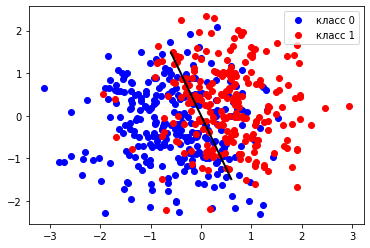

In [ ]:
cols = ['blue', 'red']

for k in np.unique(Y_test):
    plt.plot(X_test[Y_test==k,0], X_test[Y_test==k,1], 'o', 
             label='класс {}'.format(k), color=cols[k])

plt.plot(*get_line(*model.coef_[0], x_min=-0.6, x_max=0.6), 
         linewidth=2, color='black')

plt.legend(loc='best')
plt.show()
